In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Free-Boundary`


In [2]:
using Plots
using IMAS
using FUSE
using FusionMaterials
using VacuumFields

In [3]:
ini, act = FUSE.case_parameters(:ITER; init_from=:ods);
dd = IMAS.dd()
@time dd = FUSE.init(dd, ini, act);

actors: HCD
actors:  SimpleEC
actors:  SimpleIC
actors:  SimpleLH
actors:  SimpleNB
actors:  SimplePellet
actors: Current
actors:  SteadyStateCurrent
actors: CXbuild


141.351757 seconds (299.94 M allocations: 20.035 GiB, 4.77% gc time, 99.35% compilation time: <1% of which was recompilation)


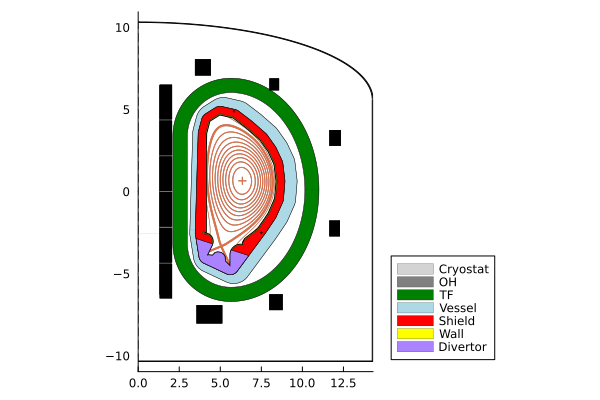

In [4]:
plot(dd.equilibrium; color=:gray, cx=true)
plot!(dd.build)
plot!(dd.pf_active)

In [5]:
active_coils = VacuumFields.IMAS_pf_active__coils(dd; green_model=:quad)[1:end-2]
active_coils = vcat(active_coils[1:6],reverse(active_coils[7:end]))

bd = dd.build

kvessel = IMAS.get_build_indexes(bd.layer; type=FUSE._vessel_, fs=FUSE._lfs_)

kout = kvessel[end]
kin = kvessel[1] - 1
quads = FUSE.layer_quads(bd.layer[kin], bd.layer[kout], 0.05, 30)

# convert quads to VacuumFields.QuadCoil
passive_coils = VacuumFields.QuadCoil[VacuumFields.QuadCoil(R, Z) for (R, Z) in quads]

# Compute resistance based on material resistivity & geometry of coil
mat_vv = Material(bd.layer[kout].material)
if ismissing(mat_vv) || ismissing(mat_vv.electrical_conductivity)
    mat_vv = Material(:steel)
end
eta = 1.0 / mat_vv.electrical_conductivity(; temperature=0.0)
if !ismissing(eta)
    for coil in passive_coils
        coil.resistance = VacuumFields.resistance(coil, eta)
    end
end

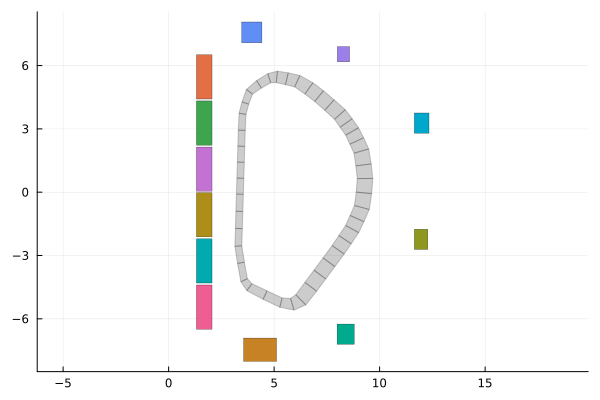

In [6]:
plot(passive_coils)
plot!(active_coils)

In [20]:
using LinearAlgebra

n_active = length(active_coils)
n_passive = length(passive_coils)

Mcc = zeros(n_active, n_active)
Mvv = zeros(n_passive, n_passive)
Mvc = zeros(n_passive, n_active)

# Coil-Coil
for i=1:n_active, j=1:n_active
    Mcc[i,j] = mutual(active_coils[i],active_coils[j])
end

# Vessel-Vessel
for i=1:n_passive, j=1:n_passive
    Mvv[i,j] = mutual(passive_coils[i],passive_coils[j])
end

# Vessel-Coil
for i=1:n_passive, j=1:n_active
    Mvc[i,j] = mutual(passive_coils[i],active_coils[j])
end
Mcv = transpose(Mvc)

12×148 transpose(::Matrix{Float64}) with eltype Float64:
 0.000151127  0.000176642  0.000207398  …  5.10436e-5   5.61784e-5
 0.000376478  0.000446394  0.000527198     0.000102265  0.000114655
 0.000844211  0.000903783  0.000930215     0.000233077  0.000266131
 0.00075333   0.000659693  0.000566911     0.000562569  0.000633044
 0.000312344  0.0002637    0.000223302     0.000890082  0.00087165
 0.000128134  0.000110716  9.6118e-5    …  0.000520988  0.000457653
 0.000263428  0.000236754  0.000213372     0.000797572  0.00071352
 0.000279146  0.000259666  0.000241562     0.000545995  0.000518688
 0.000338491  0.000330627  0.000321993     0.000391744  0.000394095
 0.000356437  0.000365417  0.000373489     0.000283725  0.000294076
 0.000166141  0.00017868   0.000192039  …  9.63872e-5   0.000102187
 0.000136731  0.000153552  0.00017303      6.13489e-5   6.61446e-5

## Circuit Equation In Vacuum

$$
M_{cc} \cdot dI_c   + M_{cv}\cdot dI_v + R_c \cdot I_c = V_c
$$

$$
M_{vc} \cdot dI_c   + M_{vv}\cdot dI_v + R_v \cdot I_v = 0
$$

Combine and rearrange to create a differential algebraic equation (DAE) in mass matrix form
$$
M \cdot dI  = V(t) - R \cdot I
$$


$$
V_c = C*V_{ps}
$$

In [21]:
M = Symmetric([Mcc Mcv; Mvc Mvv]);
R = diagm([VacuumFields.resistance(c) for c in vcat(active_coils, passive_coils)])
Rv = diagm([VacuumFields.resistance(c) for c in passive_coils])
n_c = size(Mcc,1)
n_v = size(Mvv,1)
T = 1
#V(t) = vcat([1e3*sin(t/T + 2pi*i/n_c) for i in 1:n_c],zeros(n_v))
t_ramp = 50.0
V(t) = 1e3*vcat(fill(t < t_ramp ? t/t_ramp : 1.0,1),zeros(n_c - 1 + n_v))

V (generic function with 1 method)

In [10]:
using DifferentialEquations
using Plots

function vacuum_evolution(dJ, J, p, t)
    dJ .= V(t) .- R*J 
    nothing
end

f = ODEFunction(vacuum_evolution, mass_matrix = M)
prob_mm = ODEProblem(f, zeros(n_c+n_v), (0.0, 200.0))
sol = solve(prob_mm, Rodas5(), reltol = 1e-8, abstol = 1e-8);

In [11]:
using Interact

WebIO._IJuliaInit()

In [12]:
c = cgrad(:seismic)

J = hcat(sol.u...);

Jmax = maximum(abs.(J))/1e3

a = @animate for time_index=1:size(J,2)
    for (i,coil) in enumerate(vcat(active_coils,passive_coils))
        #Jmax = maximum(abs.(J[:,time_index]))
        current_color_index = (J[i,time_index] + Jmax) / (2 * Jmax)
        if i==1
            plot(coil,color=c[current_color_index])
        else
            plot!(coil,color=c[current_color_index])
        end
    end
    plot!()
end

Animation("/tmp/jl_wQIbB5", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png", "000201.png"])

[ Info: Saved animation to /home/lstagner/Free-Boundary/tmp.gif


Plots.AnimatedGif("/home/lstagner/Free-Boundary/tmp.gif")
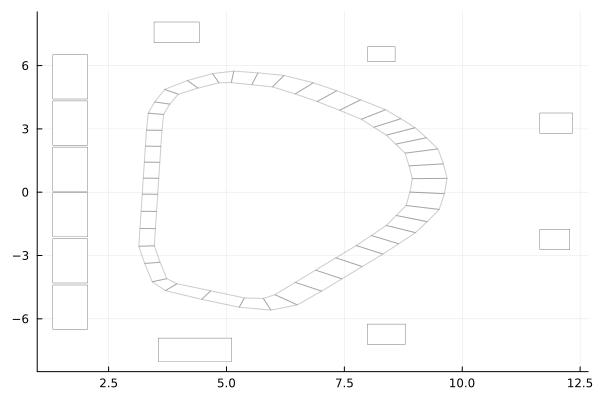

In [13]:
g = gif(a, fps=32)
display(g)

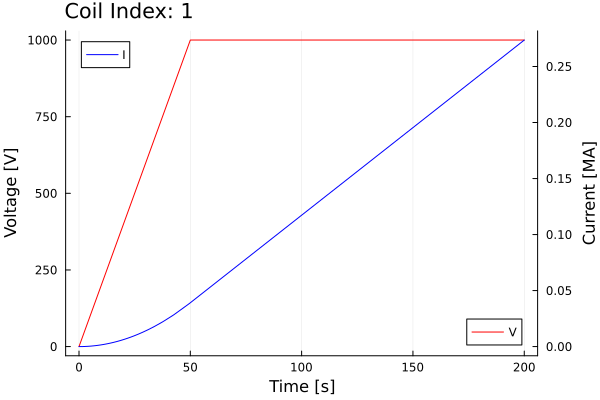

In [14]:
kw = (; title_loc = :left)
i = 1

Vs = getindex.(V.(sol.t),i)

plot( sol.t, Vs, xaxis = "Time [s]", yaxis = "Voltage [V]", label="V",color = :red, title="Coil Index: $i"; kw...)
plot!(twinx(), sol.t,J[i,:]/1e6, yaxis = "Current [MA]", label="I",color = :blue; kw...)

## Toksys ITER

In [22]:
function create_parallelogram(X)
    Z,R,dz,dr,ac,ac2 = X
    if !iszero(ac)
        tac = tan(deg2rad(ac))
        x1, y1 = 0.0, 0.0
        x2, y2 = dr, dr*tac
        x3, y3 = dr, dr*tac + dz
        x4, y4 = 0.0, dz
    elseif !iszero(ac2)
        tac = tan(deg2rad(ac2))
        x1, y1 = 0.0, 0.0
        x2, y2 = dr, 0.0
        x3, y3 = dr + dz/tac, dz
        x4, y4 = dz/tac, dz
    else
        x1, y1 = R-0.5*dr, Z - 0.5*dz
        x2, y2 = R+0.5*dr, Z - 0.5*dz
        x3, y3 = R+0.5*dr, Z + 0.5*dz
        x4, y4 = R-0.5*dr, Z + 0.5*dz
    end
    r_off = (4*R - (x1 + x2 + x3 + x4))/4
    z_off = (4*Z - (y1 + y2 + y3 + y4))/4

    rvals = [x1 + r_off, x2 + r_off, x3 + r_off, x4 + r_off]
    zvals = [y1 + z_off, y2 + z_off, y3 + z_off, y4 + z_off]

    return reverse(rvals), reverse(zvals)
end

function create_triangle(X)
    x1,y1,x2,y2,x3,y3 = X
    xvals = [x1,x2,x3]
    yvals = [y1,y2,y3]
    return xvals, yvals
end

function load_vvdata(tvvdata::Matrix)

    if size(tvvdata)[1] == 7
        polys = [t[7] == 0 ? create_parallelogram(t[1:6]) : create_triangle(t[1:6]) for t in eachcol(tvvdata)];
    else
        polys = [create_parallelogram(t) for t in eachcol(tvvdata)]
    end

    return polys
end

function vvdata_coils(vvdata, rv)
    quads = load_vvdata(vvdata)
    passive_coils = VacuumFields.QuadCoil[VacuumFields.QuadCoil(R, Z) for (R, Z) in quads]
    for (i,coil) in enumerate(passive_coils)
        coil.resistance = rv[i]
    end
    return passive_coils
end

vvdata_coils (generic function with 1 method)

In [34]:
?cp

search: curve_points create_parallelogram copyat_or_push! CKLLSRK85_4P_3R



```
cp(src::AbstractString, dst::AbstractString; force::Bool=false, follow_symlinks::Bool=false)
```

Copy the file, link, or directory from `src` to `dst`. `force=true` will first remove an existing `dst`.

If `follow_symlinks=false`, and `src` is a symbolic link, `dst` will be created as a symbolic link. If `follow_symlinks=true` and `src` is a symbolic link, `dst` will be a copy of the file or directory `src` refers to. Return `dst`.

!!! note
    The `cp` function is different from the `cp` command. The `cp` function always operates on the assumption that `dst` is a file, while the command does different things depending on whether `dst` is a directory or a file. Using `force=true` when `dst` is a directory will result in loss of all the contents present in the `dst` directory, and `dst` will become a file that has the contents of `src` instead.


---

```
cp(src::AbstractPath, dst::AbstractPath; force=false, follow_symlinks=false)
```

Copy the file or directory from `src` to `dst`. An existing `dst` will only be overwritten if `force=true`. If the path types support symlinks then `follow_symlinks=true` will copy the contents of the symlink to the destination.


In [36]:
using MAT
iter_mat = matread("ss_iter.mat")

Dict{String, Any} with 2 entries:
  "tok_data_struct" => Dict{String, Any}("gbr2c"=>[-2.20387e-7 -4.65898e-7 … -1…
  "iter_system"     => Dict{String, Any}("output_signals"=>Matrix{Float64}(unde…

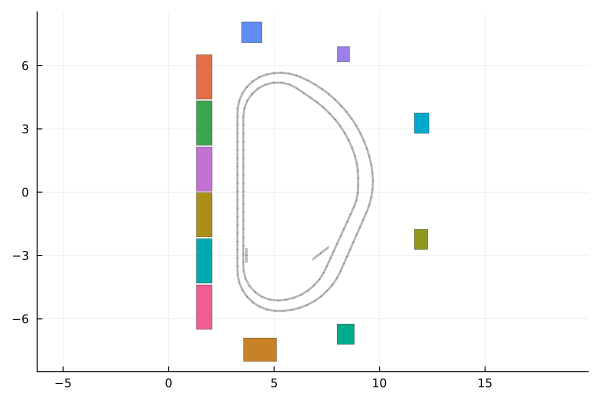

In [23]:
vvdata = iter_mat["tok_data_struct"]["vvdata"]
rv = iter_mat["tok_data_struct"]["resv"][:,1]

passive_coils = vvdata_coils(vvdata, rv)

plot(passive_coils)
plot!(active_coils)

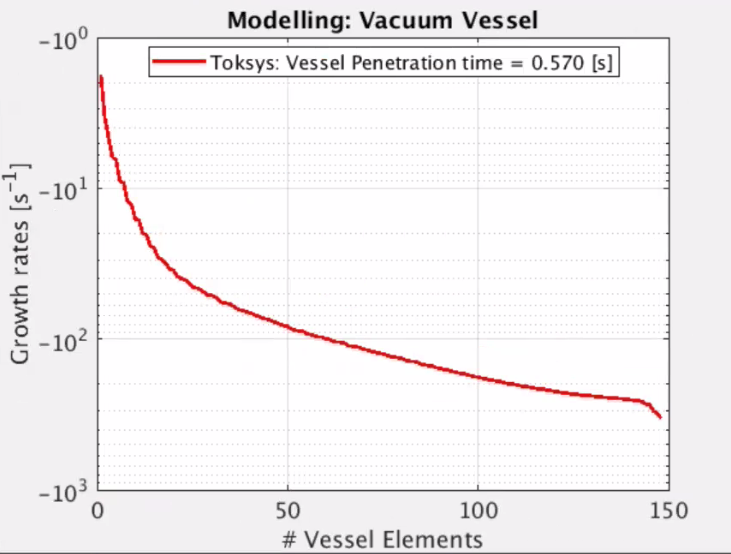

FUSE: gamma = -1.7540855994343474
FUSE: Penetration time = 0.5700976054546467 s


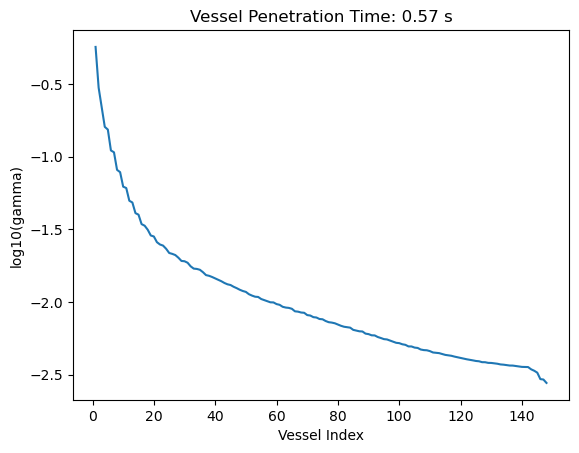

PyObject Text(0.5, 1.0, 'Vessel Penetration Time: 0.57 s')

In [31]:
n_passive = length(passive_coils)
Mvv = zeros(n_passive, n_passive)
# Vessel-Vessel
for i=1:n_passive, j=1:n_passive
    Mvv[i,j] = mutual(passive_coils[i],passive_coils[j])
end

# Resistances
Rv = diagm([VacuumFields.resistance(c) for c in passive_coils])

evals, evecs = eigen(-inv(Mvv)*Rv,sortby=-)

gamma = evals[1]
println("FUSE: gamma = $(gamma)")
println("FUSE: Penetration time = $(-inv(maximum(evals))) s")

import PyPlot

fig, ax = PyPlot.plt.subplots()
ax.plot(1:length(evals), sign.(evals) .* log10.(sign.(evals) .* evals))
ax.set_ylabel("log10(gamma)")
ax.set_xlabel("Vessel Index")
ax.set_title("Vessel Penetration Time: $(round(-inv(gamma),sigdigits=3)) s")

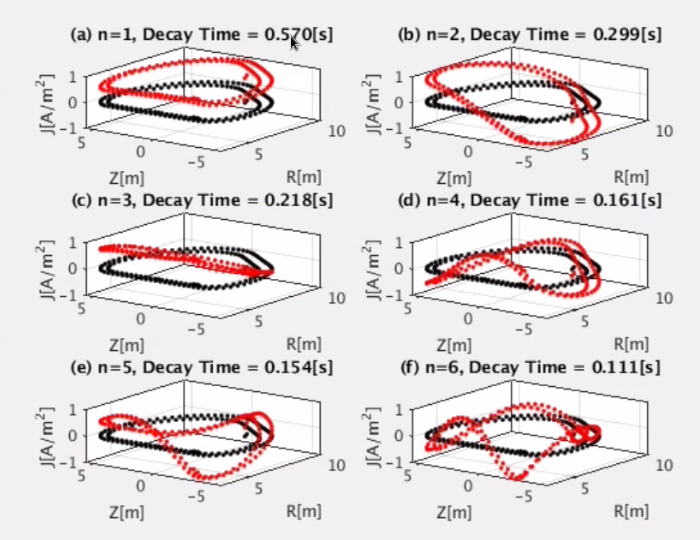

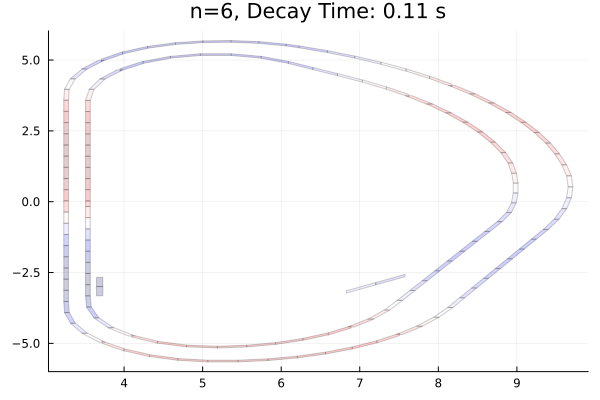

In [27]:
c = cgrad(:seismic)
pc_areas = VacuumFields.area.(passive_coils)
eigind = 6
eigvec = evecs[:,eigind] ./ pc_areas
evec_max = maximum(abs.(eigvec))*sign(eigvec[1])
for (i,coil) in enumerate(passive_coils)
    current_color_index = (eigvec[i] + evec_max) / (2 * evec_max)
    if i==1
        plot(coil,color=c[current_color_index])
    else
        plot!(coil,color=c[current_color_index])
    end
end
plot!(title="n=$eigind, Decay Time: $(round(-inv(evals[eigind]),sigdigits=3)) s")

gamma = -1.7528836363439382
penetration time = 0.5704885248890459 s


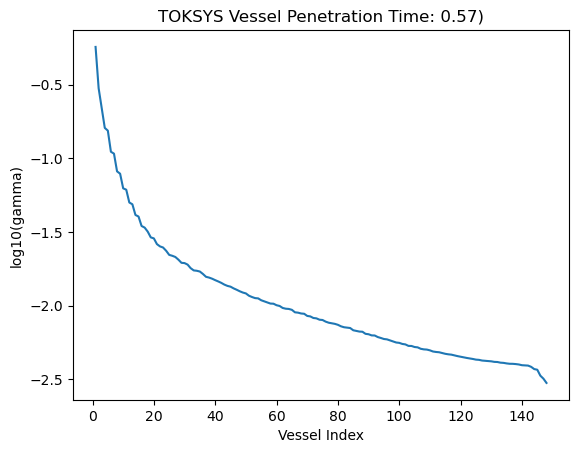

PyObject Text(0.5, 1.0, 'TOKSYS Vessel Penetration Time: 0.57)')

In [30]:
ts_Mvv = iter_mat["tok_data_struct"]["mvv"]
ts_Rv = Diagonal(iter_mat["tok_data_struct"]["resv"][:,1])

evals, evecs = eigen(-inv(ts_Mvv)*ts_Rv,sortby=-)

gamma = evals[1]
println("gamma = $(gamma)")
println("penetration time = $(-inv(maximum(evals))) s")

fig, ax = PyPlot.plt.subplots()
ax.plot(1:length(evals), sign.(evals) .* log10.(sign.(evals) .* evals))
ax.set_ylabel("log10(gamma)")
ax.set_xlabel("Vessel Index")
ax.set_title("TOKSYS Vessel Penetration Time: $(round(-inv(gamma),sigdigits=3))")